In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
N=40
combined_df = pd.read_csv(f"calibrated_CI_ensemble_test_fewerhist_N{N}_DR0.05.csv")

meta_df = pd.read_csv("../uuss_data/p_resampled/uuss_test_fewerhist.csv")

In [26]:
widths = (combined_df.ub_y - combined_df.lb_y).values

30277
34407
15222


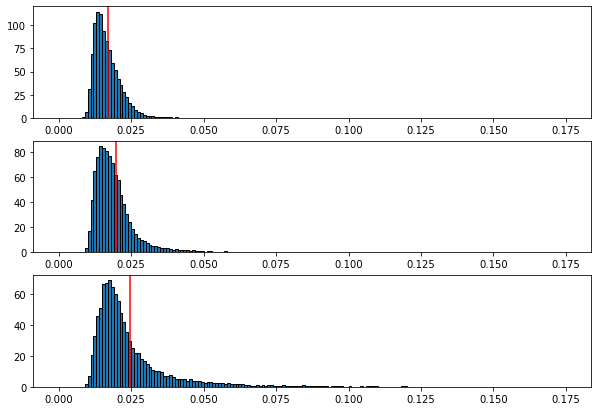

In [27]:
trimmed_std=combined_df["std"].values
one_inds = meta_df[meta_df["pick_quality"] == 1].index
print(len(one_inds))

two_inds = meta_df[meta_df["pick_quality"] == 0.75].index
print(len(two_inds))

three_inds = meta_df[meta_df["pick_quality"] == 0.5].index
print(len(three_inds))
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
bins = axes[0].hist(trimmed_std[one_inds], density=True, bins=np.arange(0, 0.176, 0.001), edgecolor="k");
bins2 = axes[1].hist(trimmed_std[two_inds], density=True, bins=bins[1], edgecolor="k");
bins3 = axes[2].hist(trimmed_std[three_inds], density=True, bins=bins[1], edgecolor="k");
axes[0].axvline(np.mean(trimmed_std[one_inds]), color="red");
axes[1].axvline(np.mean(trimmed_std[two_inds]), color="red");
axes[2].axvline(np.mean(trimmed_std[three_inds]), color="red");

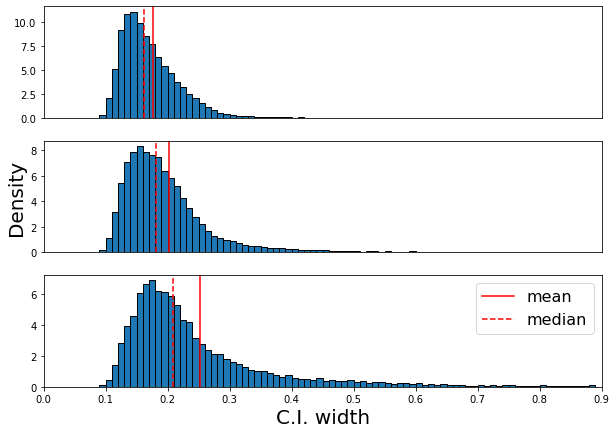

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
bins = axes[0].hist(widths[one_inds], density=True, bins=np.arange(0, 0.9, 0.01), edgecolor="k");
bins2 = axes[1].hist(widths[two_inds], density=True, bins=bins[1], edgecolor="k");
bins3 = axes[2].hist(widths[three_inds], density=True, bins=bins[1], edgecolor="k");

axes[0].axvline(np.mean(widths[one_inds]), color="red");
axes[1].axvline(np.mean(widths[two_inds]), color="red");
axes[2].axvline(np.mean(widths[three_inds]), color="red", label="mean");

axes[0].axvline(np.median(widths[one_inds]), color="red", linestyle="--");
axes[1].axvline(np.median(widths[two_inds]), color="red", linestyle="--");
axes[2].axvline(np.median(widths[three_inds]), color="red", linestyle="--", label="median");

axes[2].set_xlabel("C.I. width", fontsize=20)
axes[1].set_ylabel("Density", fontsize=20)
axes[2].legend(fontsize=16)
for ax in range(3):
    axes[ax].set_xlim([0, 0.9])
    
axes[0].set_xticks([]);
axes[1].set_xticks([]);

In [29]:
np.sum(widths < 0.1)

204

In [30]:
((combined_df["y_act"] > combined_df["lb_y"]) & (combined_df["y_act"] < combined_df["ub_y"])).sum()/len(combined_df)

0.8887693039321203

In [31]:
((combined_df["y_act"] > (combined_df["y_pred"])-combined_df["std"]) & (combined_df["y_act"] < (combined_df["y_pred"])+combined_df["std"])).sum()/len(combined_df)

0.40233524391159614

In [32]:
combined_df

,Unnamed: 0,y_pred,std,lb_y,ub_y,y_act
0,0,0.288105,0.014237,0.213158,0.359969,0.32
1,1,0.195140,0.013044,0.126474,0.260983,0.20
2,2,0.413204,0.019161,0.312335,0.509924,0.43
3,3,0.465821,0.021395,0.353188,0.573821,0.45
4,4,0.137764,0.014536,0.061240,0.211141,0.18
...,...,...,...,...,...,...
79901,79901,0.144944,0.015333,0.064227,0.222340,0.11
79902,79902,0.213369,0.016203,0.128071,0.295157,0.32
79903,79903,0.377150,0.016657,0.289461,0.461232,0.40
79904,79904,0.416300,0.022743,0.296571,0.531104,0.46


# SNR

In [33]:
snr_values = np.loadtxt("../uuss_data/P_test_fewerhist_snrs.txt")

In [34]:
#from sklearn.linear_model import QuantileRegressor

In [35]:
#reg = QuantileRegressor(quantile=0.95).fit(snr_values[:1000].reshape(-1, 1), widths[:1000], solver="highs")

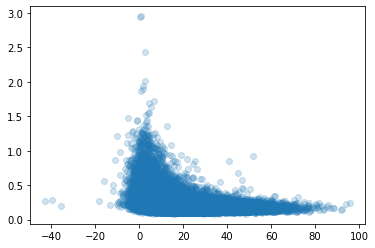

In [36]:
plt.scatter(snr_values, widths, alpha=0.2)

(0.0, 1.8)

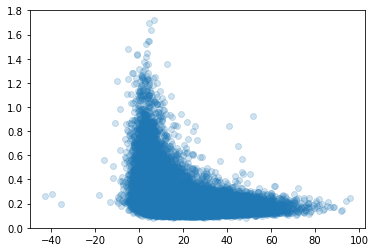

In [37]:
plt.scatter(snr_values, widths, alpha=0.2)
plt.ylim([0, 1.80])

In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [39]:
data = pd.DataFrame({"snr":snr_values, "width":widths})
mod = smf.quantreg("width ~ snr + I(snr ** 2.0)", data)
#mod = smf.quantreg("width ~ snr", data)

res = mod.fit(q=0.5)
print(res.summary())

quantiles = [0.05, 0.5, 0.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["snr"]] + res.conf_int().loc[
        "snr"].tolist()


models = [mod.fit(q=x) for x in quantiles]
#models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])


                         QuantReg Regression Results                          
Dep. Variable:                  width   Pseudo R-squared:              0.06572
Model:                       QuantReg   Bandwidth:                    0.005911
Method:                 Least Squares   Sparsity:                       0.1286
Date:                Fri, 23 Dec 2022   No. Observations:                79906
Time:                        16:10:42   Df Residuals:                    79903
                                        Df Model:                            2
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2411      0.001    389.617      0.000       0.240       0.242
snr              -0.0051   5.61e-05    -91.215      0.000      -0.005      -0.005
I(snr ** 2.0)  7.281e-05   1.09e-06     66.938      0.000    7.07e-05    7.49e-05

The condition number is large, 2.11e

In [40]:
models[1].predict({'snr':35})

0    0.151101
dtype: float64

In [41]:
models[1].predict({'snr':0}) - models[1].predict({'snr':35})

0    0.090004
dtype: float64

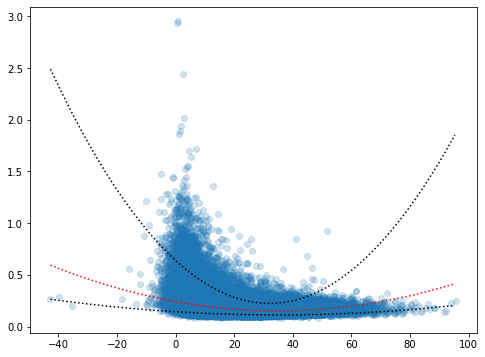

In [42]:
x = np.arange(data.snr.min(), data.snr.max(), 1)
get_y = lambda a, b: a + b * x
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(snr_values, widths, alpha=0.2)
ax.plot(x, models[0].predict({'snr':x}), linestyle="dotted", color="k")
ax.plot(x, models[-1].predict({'snr':x}), linestyle="dotted", color="k")
ax.plot(x, models[1].predict({'snr':x}), linestyle="dotted", color="red")

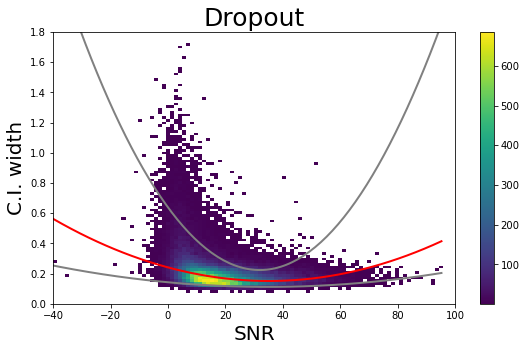

In [43]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, range=[[-40, 100], [0, 1.8]]);
ax.set_ylabel("C.I. width", fontsize=20)
ax.set_xlabel("SNR", fontsize=20)
ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

plt.colorbar(h[-1], ax=ax)

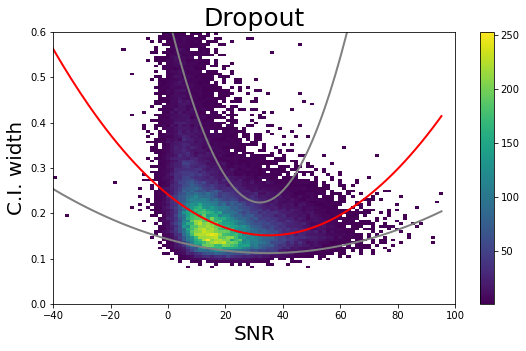

In [44]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, range=[[-40, 100], [0, 0.6]]);
ax.set_ylabel("C.I. width", fontsize=20)
ax.set_xlabel("SNR", fontsize=20)
ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

plt.colorbar(h[-1], ax=ax)

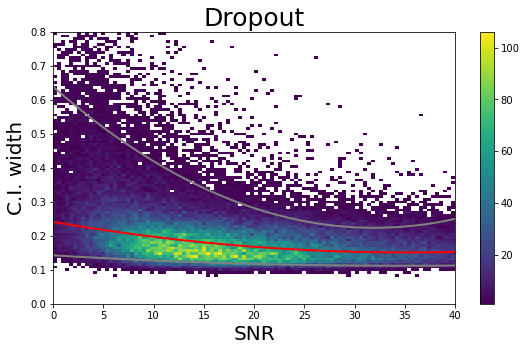

In [45]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, range=[[0, 40], [0, 0.8]]);
ax.set_ylabel("C.I. width", fontsize=20)
ax.set_xlabel("SNR", fontsize=20)
ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="-", color="gray", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

plt.colorbar(h[-1], ax=ax)

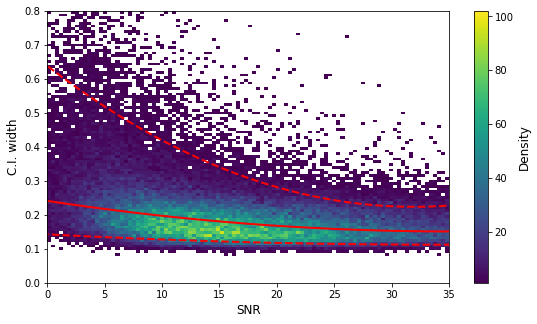

In [50]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, widths, bins=(100, 100), cmap=plt.cm.viridis, cmin=1, 
              range=[[0, 35], [0, 0.8]], vmin=1, vmax=102);
ax.set_ylabel("C.I. width", fontsize=12)
ax.set_xlabel("SNR", fontsize=12)
#ax.set_title("Dropout", fontsize=25)

ax.plot(x, models[0].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

cb = plt.colorbar(h[-1], ax=ax)
cb.set_label(label='Density', fontsize=12)

In [47]:
np.nanmax(h[0])

96.0

In [51]:
data = pd.DataFrame({"snr":snr_values, "std":combined_df["std"].values})

mod = smf.quantreg("std ~ snr + I(snr ** 2.0)", data)
#mod = smf.quantreg("width ~ snr", data)

res = mod.fit(q=0.5)
print(res.summary())

quantiles = [0.05, 0.5, 0.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["snr"]] + res.conf_int().loc[
        "snr"].tolist()


models = [mod.fit(q=x) for x in quantiles]

                         QuantReg Regression Results                          
Dep. Variable:                    std   Pseudo R-squared:              0.06572
Model:                       QuantReg   Bandwidth:                   0.0005734
Method:                 Least Squares   Sparsity:                      0.01247
Date:                Fri, 23 Dec 2022   No. Observations:                79906
Time:                        16:14:19   Df Residuals:                    79903
                                        Df Model:                            2
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0234      6e-05    389.654      0.000       0.023       0.024
snr              -0.0005   5.44e-06    -91.298      0.000      -0.001      -0.000
I(snr ** 2.0)   7.07e-06   1.06e-07     67.010      0.000    6.86e-06    7.28e-06

The condition number is large, 2.11e

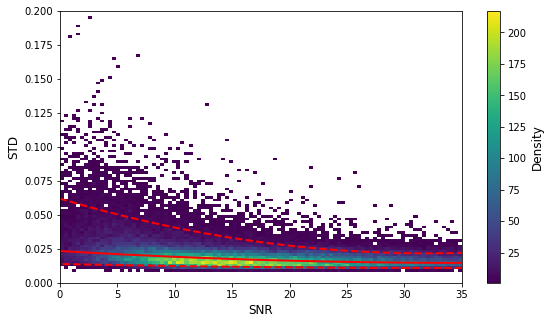

In [56]:
fig, ax = plt.subplots(figsize=(9, 5))
h = ax.hist2d(snr_values, combined_df["std"], bins=((100, 100)), cmap=plt.cm.viridis, cmin=1,
              range=[[0, 35], [0, 0.2]], vmin=1, vmax=217);
ax.set_ylabel("STD", fontsize=12)
ax.set_xlabel("SNR", fontsize=12)
#ax.set_title("Dropout", fontsize=25)
ax.plot(x, models[0].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[-1].predict({'snr':x}), linestyle="--", color="red", linewidth=2)
ax.plot(x, models[1].predict({'snr':x}), linestyle="-", color="red", linewidth=2)

cb = plt.colorbar(h[-1], ax=ax)
cb.set_label(label='Density', fontsize=12)

In [53]:
np.nanmax(h[0])

217.0